In [ ]:
import time
import numpy as np
from numpy import mean, std, dstack
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Dropout, InputLayer
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Layer
import xlsxwriter
from tensorflow.keras.regularizers import l2
from keras import layers
import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

In [ ]:
class Time2Vec(Layer):
    def __init__(self, kernel_size=1):
        super(Time2Vec, self).__init__()
        self.k = kernel_size

    def build(self, input_shape):
        self.w0 = self.add_weight(name="w0", shape=(1,), initializer="uniform", trainable=True)
        self.b0 = self.add_weight(name="b0", shape=(1,), initializer="uniform", trainable=True)
        self.w = self.add_weight(name="w", shape=(input_shape[-1], self.k), initializer="uniform", trainable=True)
        self.b = self.add_weight(name="b", shape=(self.k,), initializer="uniform", trainable=True)

    def call(self, inputs):
        v1 = self.w0 * inputs + self.b0
        v2 = tf.math.sin(tf.matmul(inputs, self.w) + self.b)
        return tf.concat([v1, v2], axis=-1)

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_classes,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv1D(filters=64, kernel_size=8, activation='relu', bias_regularizer='l2')(inputs)
    x = layers.MaxPooling1D(pool_size=17,strides=9)(x)
    x = Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    x = Time2Vec()(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)


In [ ]:
def evaluate_model(trainX, trainy, testX, testy, sujet):
    verbose, epochs, batch_size = 1, 200, 64
    # Extract dimensions from training data:
    n_timesteps = trainX.shape[1]
    d_model= trainX.shape[2]  # This is 12 in your case
    n_outputs = trainy.shape[1]

    print("Train Data Shape:", trainX.shape)  # (num_samples, sequence_length, 12)
    print("Test Data Shape:", testX.shape)

    # Build the classifier model using the raw input dimension and then projecting internally.
    model = build_model(
       input_shape=(n_timesteps, d_model),
       head_size=128,
       num_heads=12,
       num_classes=n_outputs,
       ff_dim=24,
       num_transformer_blocks=1,
       mlp_units=[128],
       mlp_dropout=0.4,
       dropout=0.25,
    )
    model.summary()

    # Compile the model with categorical crossentropy and Adam optimizer.
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.0001),
                  metrics=['accuracy'])


    # Train the model
    start = time.time()
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=[history])
    train_time = time.time() - start  # seconds

    # Save the model
    model.save('D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\models\Transformer_model_' + str(sujet) + '.h5')

    # Evaluate on training data
    loss_train, accuracy_train = model.evaluate(trainX, trainy, batch_size=batch_size, verbose=1)
    start = time.time()
    loss_test, accuracy_test = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    test_time = time.time() - start  # seconds

    # Predict on test data and convert predictions to class indices
    y_pred = np.argmax(model.predict(testX), axis=-1)
    testy_indices = [np.argmax(y) for y in testy]

    return loss_train, accuracy_train, loss_test, accuracy_test, y_pred, testy_indices, train_time, test_time


def summarize_results(scores, losses):
    m, s = mean(scores), std(scores)
    mL, sL = mean(losses), std(losses)
    print('\nAccuracy: %.5f (+/-%.5f)' % (m, s))
    print('Loss: %.5f (+/-%.5f)' % (mL, sL))

def run_my_experiment(sujet):
    # Load data from MATLAB file; update the path as needed.
    data = loadmat(fr"D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\data\normalized_data\DB3_s" + str(sujet) + "_E1_A1_150_100_N.mat")

    train_data = data['train_data']      # shape: (num_train_samples, sequence_length, d_model)
    train_labels = data['train_labels']    # shape: (num_train_samples, num_classes)
    test_data = data['test_data']          # shape: (num_test_samples, sequence_length, d_model)
    test_labels = data['test_labels']      # shape: (num_test_samples, num_classes)

    scores = list()
    losses = list()

    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = evaluate_model(
        train_data, train_labels, test_data, test_labels, sujet
    )

    print('>#%d: ' % (sujet))
    print('  train accuracy: %.5f' % (score_train))
    print('  train loss    : %.5f' % (loss_train))
    print('  test accuracy: %.5f' % (score_test))
    print('  test loss    : %.5f' % (loss_test))
    scores.append(score_test)
    losses.append(loss_test)
    summarize_results(scores, losses)

    return loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time


Train Data Shape: (3105, 300, 12)
Test Data Shape: (1431, 300, 12)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 293, 64)   │      6,208 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 31, 64)    │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 31, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 31, 64)    │        256 │ dropout[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ times_block         │ (None, 31, 96)    │    170,080 │ batch_normalizat… │
│ (TimesBlock)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ times_block_1       │ (None, 31, 96)    │    255,072 │ times_block[0][0] │
│ (TimesBlock)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec           │ (None, 31, 97)    │        194 │ times_block_1[0]… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 97)    │    600,673 │ time2_vec[0][0],  │
│ (MultiHeadAttentio… │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 31, 97)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 31, 97)    │        194 │ dropout_2[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 31, 97)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 31, 24)    │      2,352 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 31, 97)    │      2,425 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 97)    │        194 │ conv1d_2[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 31, 97)    │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 97)        │          0 │ add_1[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,544 │ global_average_p

 Total params: 1,052,256 (4.01 MB)

 Trainable params: 1,052,128 (4.01 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 36s 313ms/step - accuracy: 0.0702 - loss: 3.1054
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.0919 - loss: 2.8890
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.0866 - loss: 2.8398
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.0809 - loss: 2.8057
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.1007 - loss: 2.7777
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 305ms/step - accuracy: 0.1090 - loss: 2.7425
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.1150 - loss: 2.6940
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - accuracy: 0.1388 - loss: 2.6236
Epoch 9/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step - accuracy: 0.1764 - loss: 2.4894
Epoch 10/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.1968 - loss: 2.3978
Epoch 11/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 15s 311ms/step - accuracy: 0.2044 - loss: 2.2962
Epoch 12/150
49/49 ━━━━━━━━━━━

49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.8559 - loss: 0.4495
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5315 - loss: 1.7174
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step
>#1:
  train accuracy: 0.83188
  train loss    : 0.49023
  test accuracy: 0.55416
  test loss    : 1.79524

Accuracy: 0.55416 (+/-0.00000)
Loss: 1.79524 (+/-0.00000)


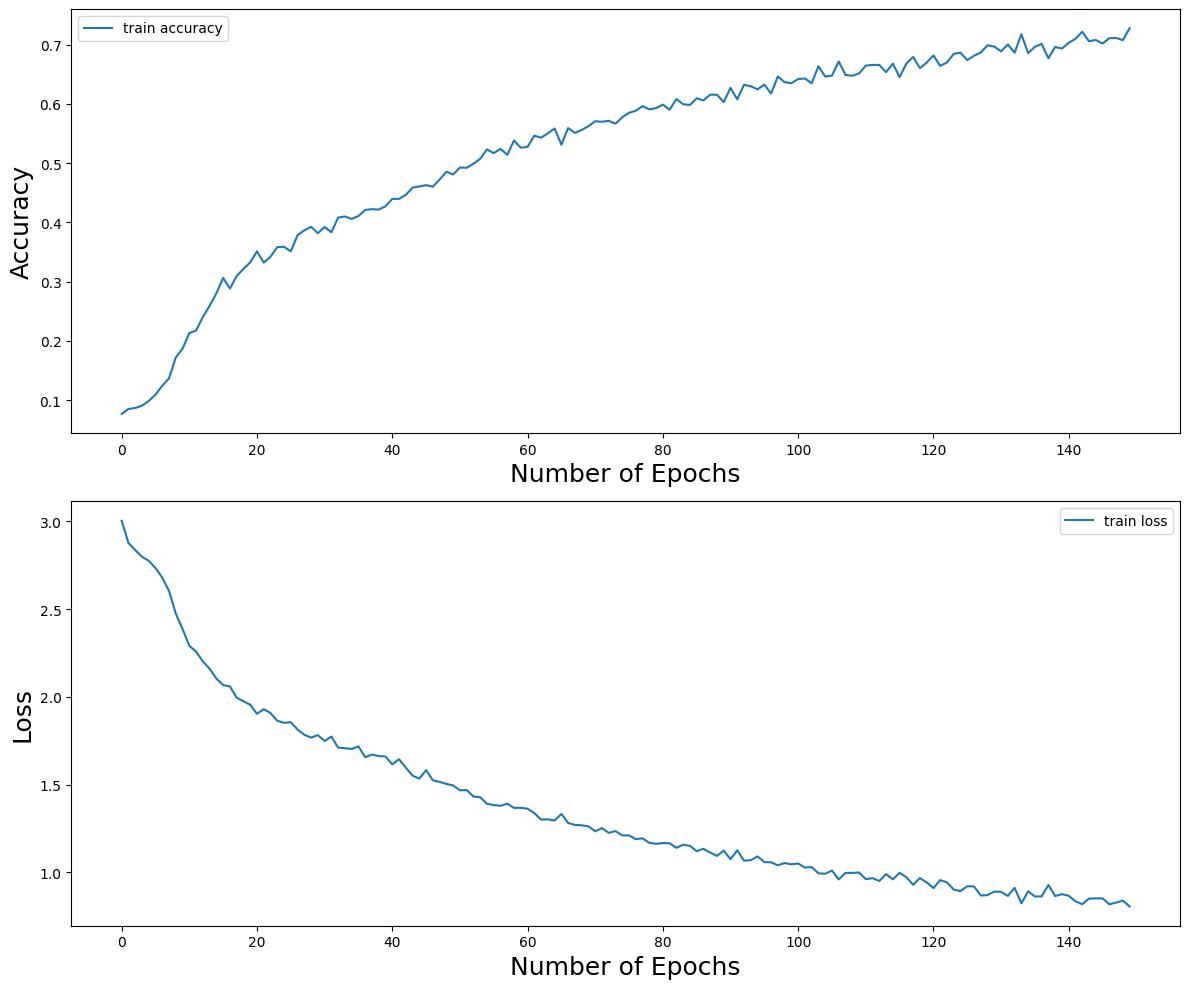

Train Data Shape: (2434, 300, 12)
Test Data Shape: (1075, 300, 12)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300, 12)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 293, 64)   │      6,208 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 31, 64)    │          0 │ conv1d_3[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 31, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 64)    │        256 │ dropout_5[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ times_block_2       │ (None, 31, 96)    │    170,080 │ batch_normalizat… │
│ (TimesBlock)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ times_block_3       │ (None, 31, 96)    │    255,072 │ times_block_2[0]… │
│ (TimesBlock)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time2_vec_1         │ (None, 31, 97)    │        194 │ times_block_3[0]… │
│ (Time2Vec)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 31, 97)    │    600,673 │ time2_vec_1[0][0… │
│ (MultiHeadAttentio… │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 31, 97)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 97)    │        194 │ dropout_7[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 31, 97)    │          0 │ layer_normalizat… │
│                     │                   │            │ time2_vec_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 31, 24)    │      2,352 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 31, 24)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 31, 97)    │      2,425 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 31, 97)    │        194 │ conv1d_5[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 31, 97)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 97)        │          0 │ add_3[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     12,544 │ global_average_p

 Total params: 1,052,256 (4.01 MB)

 Trainable params: 1,052,128 (4.01 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 273ms/step - accuracy: 0.0724 - loss: 3.2540
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.0995 - loss: 2.8937
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 276ms/step - accuracy: 0.1037 - loss: 2.8211
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.1243 - loss: 2.7953
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.1224 - loss: 2.7622
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.1220 - loss: 2.7369
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - accuracy: 0.1291 - loss: 2.6983
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.1275 - loss: 2.6934
Epoch 9/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 272ms/step - accuracy: 0.1418 - loss: 2.6522
Epoch 10/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.1481 - loss: 2.6161
Epoch 11/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.1571 - loss: 2.5583
Epoch 12/150
39/39 ━━━━━━━━━━━

In [ ]:

# Main
# ==============================================================================

globel_perd = []
globel_class = []

globel_perd1 = []
globel_class1 = []

# Create a workbook and add a worksheet.
workbook = xlsxwriter.Workbook(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\xlsx\Trans_DB3_rslt.xlsx')
worksheet1 = workbook.add_worksheet('Subjects informations')

# Start from the first cell. Rows and columns are zero indexed.
row = 0

worksheet1.write(row, 0, 'Subject')
worksheet1.write(row, 1, 'Train_time')
worksheet1.write(row, 2, 'Test_time')
worksheet1.write(row, 3, 'Train_acc')
worksheet1.write(row, 4, 'Train_loss')
worksheet1.write(row, 5, 'Test_acc')
worksheet1.write(row, 6, 'Test_loss')
worksheet1.write(row, 7, 'MCC')

history = History()
for i in range(1, 12):
    loss_train, score_train, loss_test, score_test, y_pred, testy, train_time, test_time = run_my_experiment(i)

    globel_perd.append(y_pred)
    globel_class.append(testy)

    globel_perd1.extend(y_pred)
    globel_class1.extend(testy)

    mcc = matthews_corrcoef(testy, y_pred)
    mat = confusion_matrix(testy, y_pred)

    cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
    cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\confusion_matrix\DB3_s' + str(i) + 'trans_confusion_matrix.png')

    fig, axarr = plt.subplots(figsize=(12, 6), ncols=1)
    plot_renge = int(len(history.history['accuracy']) / i)
    global_renge = len(history.history['accuracy'])
    start_renge = global_renge - plot_renge
    axarr.plot(range(plot_renge), history.history['accuracy'][start_renge: global_renge], label='train score')
    axarr.plot(range(plot_renge), history.history['loss'][start_renge: global_renge], label='train loss')
    axarr.set_xlabel('Number of Epochs', fontsize=18)
    axarr.set_ylabel('Accuracy', fontsize=18)
    axarr.set_ylim([0, 2.5])
    plt.legend()
    plt.show()
    fig.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\graphs\DB3_s' + str(i) + 'trans_graphe.png')

    # Sheet informations
    worksheet1.write(i, 0, 'Sujet ' + str(i))
    worksheet1.write(i, 1, train_time)
    worksheet1.write(i, 2, test_time)
    worksheet1.write(i, 3, score_train)
    worksheet1.write(i, 4, loss_train)
    worksheet1.write(i, 5, score_test)
    worksheet1.write(i, 6, loss_test)
    worksheet1.write(i, 7, mcc)

workbook.close()

# Save prediction
new_data = {'pred_labels': globel_perd, 'class_labels': globel_class}
savemat(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\general_results\trans_global_predection.mat', new_data)

mat = confusion_matrix(globel_class1, globel_perd1)
cfm_plot, ax = plot_confusion_matrix(mat, figsize=(10, 10), show_normed=True, show_absolute=False)
cfm_plot.savefig(fr'D:\Transformer-Based-approach-for-hand-gesture-recognition-through-EMG-signals\DB3\results\v1\general_results\trans_global_confusion_matrix.png')


